In [1]:
import pandas as pd
import numpy as np
import collections
import scipy.sparse as sp_sparse
import tables
from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc
import math

In [87]:
import tcr_emb_code
import data_processing

In [2]:
!unzip ank_spond_scrnaseq.zip

Archive:  ank_spond_scrnaseq.zip
   creating: ank_spond_scrnaseq/
  inflating: ank_spond_scrnaseq/K2_D1_metrics_summary.csv  
  inflating: ank_spond_scrnaseq/K1_vdj.clones.tsv  
  inflating: ank_spond_scrnaseq/oxford.clones.tsv  
  inflating: ank_spond_scrnaseq/I2_B1_metrics_summary.csv  
  inflating: ank_spond_scrnaseq/N_vdj.clones.tsv  
  inflating: ank_spond_scrnaseq/I1_C1_metrics_summary.csv  
  inflating: ank_spond_scrnaseq/K2_vdj.clones.tsv  
  inflating: ank_spond_scrnaseq/K1_E1_metrics_summary.csv  
  inflating: ank_spond_scrnaseq/G_vdj.clones.tsv  
  inflating: ank_spond_scrnaseq/N_F1_metrics_summary.csv  
  inflating: ank_spond_scrnaseq/I2_vdj.clones.tsv  
  inflating: ank_spond_scrnaseq/N1_F1_filtered_feature_bc_matrix.h5  
  inflating: ank_spond_scrnaseq/K2_D1_filtered_feature_bc_matrix.h5  
  inflating: ank_spond_scrnaseq/I1_C1_filtered_feature_bc_matrix.h5  
  inflating: ank_spond_scrnaseq/I1_vdj.clones.tsv  
  inflating: ank_spond_scrnaseq/G_A1_metrics_summary.csv  
  in

In [157]:
#filtered_matrix_h5_path = "data/ank_spond_scrnaseq/G_A1_filtered_feature_bc_matrix.h5"
#clones_path = 'data/ank_spond_scrnaseq/G_vdj.clones.tsv'

filtered_matrix_h5_path = "data/ank_spond_scrnaseq/I1_C1_filtered_feature_bc_matrix.h5"
clones_path = 'data/ank_spond_scrnaseq/I1_vdj.clones.tsv'

#filtered_matrix_h5_path = "data/ank_spond_scrnaseq/I2_B1_filtered_feature_bc_matrix.h5"
#clones_path = 'data/ank_spond_scrnaseq/I2_vdj.clones.tsv'

#filtered_matrix_h5_path = "data/ank_spond_scrnaseq/K1_E1_filtered_feature_bc_matrix.h5"
#clones_path = 'data/ank_spond_scrnaseq/K1_vdj.clones.tsv'

#filtered_matrix_h5_path = "data/ank_spond_scrnaseq/K2_D1_filtered_feature_bc_matrix.h5"
#clones_path = 'data/ank_spond_scrnaseq/K2_vdj.clones.tsv'

#filtered_matrix_h5_path = "data/ank_spond_scrnaseq/N1_F1_filtered_feature_bc_matrix.h5"
#clones_path = 'data/ank_spond_scrnaseq/N_vdj.clones.tsv'

In [158]:
clones = pd.read_csv(clones_path,sep = '\t')

In [159]:
clones = clones.rename(columns={'tagValueCELL':'barcode','aaSeqCDR3': 'cdr3','allVHitsWithScore':'v_gene','allJHitsWithScore':'j_gene'})


In [160]:
clones['chain'] = clones['v_gene'].str[:3]

In [161]:
def get_features_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
         
        feature_ref = {}
        feature_group = f.get_node(mat_group, 'features')
        feature_ids = getattr(feature_group, 'id').read()
        feature_names = getattr(feature_group, 'name').read()
        feature_types = getattr(feature_group, 'feature_type').read()
        feature_ref['id'] = feature_ids
        feature_ref['name'] = feature_names
        feature_ref['feature_type'] = feature_types
        tag_keys = getattr(feature_group, '_all_tag_keys').read()
        for key in tag_keys:
            key = key.decode("utf-8")
            feature_ref[key] = getattr(feature_group, key).read()
        features = pd.DataFrame(feature_ref)
        features['id'] = features['id'].str.decode('utf-8')
        features['name'] = features['name'].str.decode('utf-8')
        features['feature_type'] = features['feature_type'].str.decode('utf-8')
        features['genome'] = features['genome'].str.decode('utf-8')
        
        return features
    
def get_barcodes_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        barcodes = f.get_node(mat_group, 'barcodes').read()
        barcodes = pd.DataFrame(barcodes,columns = ['barcode'])
        barcodes['barcode'] = barcodes['barcode'].str.decode('utf-8')
        return barcodes
    
def get_matrix_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        data = getattr(mat_group, 'data').read()
        indices = getattr(mat_group, 'indices').read()
        indptr = getattr(mat_group, 'indptr').read()
        shape = getattr(mat_group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
        matrix = pd.DataFrame(matrix.toarray())
    return matrix

In [71]:
features = get_features_from_h5(filtered_matrix_h5_path)
barcodes_raw = get_barcodes_from_h5(filtered_matrix_h5_path)
matrix = get_matrix_from_h5(filtered_matrix_h5_path)

barcodes = barcodes_raw.copy()
barcodes['barcode'] = barcodes['barcode'].str.split('-',expand = True)[0]
data = clones.merge(barcodes, on='barcode')

matrix_t = matrix.T

matrix_t.columns = list(features['name'])
matrix_t.index = list(barcodes['barcode'])
matrix_t

# Scanpy

In [162]:
adata = sc.read_10x_h5(filtered_matrix_h5_path)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [163]:
adata.var_names_make_unique()

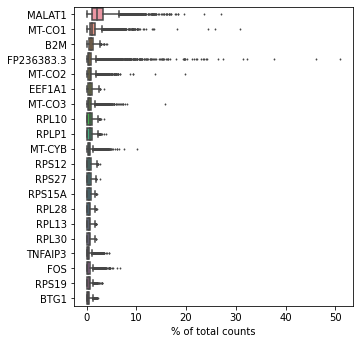

In [164]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [165]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [166]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


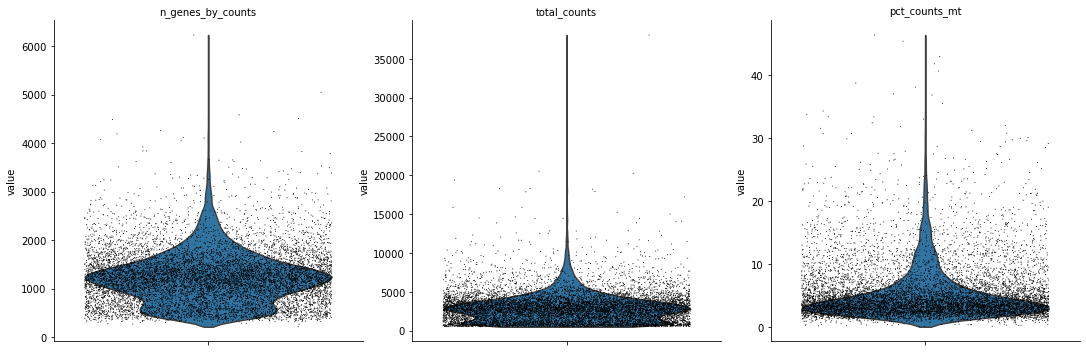

In [167]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

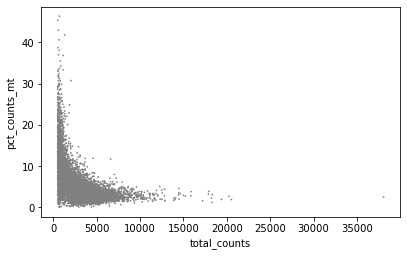

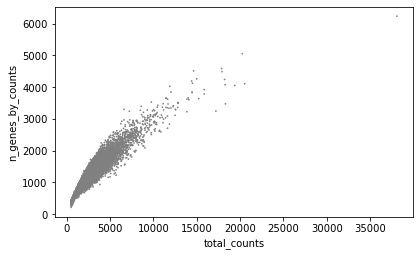

In [168]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [169]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [170]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [171]:
sc.pp.log1p(adata)

In [172]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

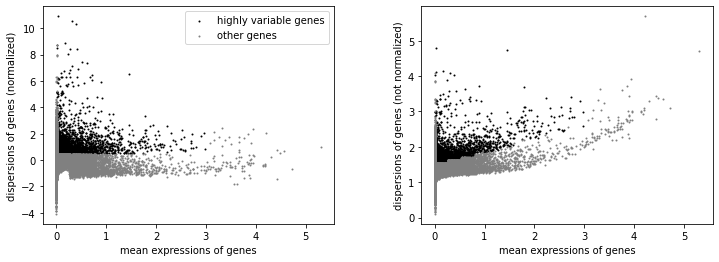

In [173]:
sc.pl.highly_variable_genes(adata)

In [174]:
adata.raw = adata

In [175]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [176]:
sc.pp.scale(adata, max_value=10)

In [177]:
sc.tl.pca(adata, svd_solver='arpack')

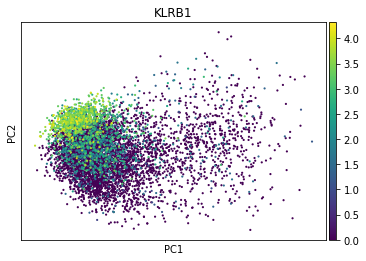

In [178]:
sc.pl.pca(adata, color='KLRB1')

In [179]:
barcodes = pd.DataFrame(sc.get.obs_df(
        adata).index,columns = ['barcode'])
barcodes['barcode'] = barcodes['barcode'].str.split('-',expand = True)[0]

In [180]:
data = clones.merge(barcodes, on='barcode')

In [181]:
KLRB1_matrix = sc.get.obs_df(
        adata,
        keys=['KLRB1'])
KLRB1_matrix['barcode'] = KLRB1_matrix.index

In [182]:
data = data.merge(KLRB1_matrix,on='barcode')

In [183]:
data['KLRB1_bool']=data['KLRB1'].apply(lambda x: 1 if x>0 else 0)

matrix_KLRB1 = matrix_t[matrix_t['KLRB1']>10 ]
matrix_KLRB1_exp = pd.DataFrame(matrix_t['KLRB1'])
matrix_KLRB1_exp['barcode'] = matrix_t.index

data['KLRB1_bool'] = data['barcode'].apply(lambda x: 1 if x in matrix_KLRB1.index else 0)

data = data.merge(matrix_KLRB1_exp,on = 'barcode')

In [184]:
data_b = data[data['chain']=='TRB']

In [186]:
prototypes_path = '/home/yuliajk/projects/tcr_emb/data_scripts/prototypes_olga.txt'
chain = 'TRB'
file_path_prefix = 'ank_spond_I1'
file_date = '270723'

In [187]:

def filter_table(data,chain):
    if chain== "TRA":
        data = data[data['chain'] == "TRA"]
    
    if chain== "TRB":
        data = data[data['chain'] == "TRB"]
    #cols_input = list(data.columns)
    data = data[-data['v_gene'].isna()]
    data = data[-data['j_gene'].isna()]
    data = data[-(data['v_gene']== "None")]
    data = data[-(data['j_gene']== "None")]
    data = data[-(data['j_gene']== "")]
    data = data[-(data['v_gene']== "")]
    data['v_gene'] = data['v_gene'].str.split(',', 1, expand=True)[0]
    data['j_gene'] = data['j_gene'].str.split(',', 1, expand=True)[0]
    data['v_gene'] = data['v_gene'].str.split('*', 1, expand=True)[0]
    data['j_gene'] = data['j_gene'].str.split('*', 1, expand=True)[0]
    data = data[-data['v_gene'].str.contains(',')]
    data = data[-data['j_gene'].str.contains(',')]

    data = data[-(data['cdr3']== "")]
    data = data[-(data['cdr3']== "None")]
    data = data[-data['cdr3'].isna()]
    data = data[-data['cdr3'].str.contains('\.')]
    data = data[-data['cdr3'].str.contains('\*')]
    
    #data = data[data['high_confidence']==True]
    data = data.reset_index(drop=True)
    return data

In [188]:
data_b = filter_table(data_b,chain)

In [189]:
#data_b = tcr_emb_code.filter_table(data_b,chain)
data_b = tcr_emb_code.data_filter_for_prototypes(data_b,prototypes_path)

In [190]:
tcr_emb_code.mir_clac(data_b, file_path_prefix, file_date, chain, prototypes_path)

In [191]:
data_dists_raw_path = 'data_scripts/' + file_path_prefix + file_date + '.dist.txt'
data_dists_raw = pd.read_csv(data_dists_raw_path, sep = '\t')

In [195]:
def mir_dists_format(data_dists_raw, data, smaller = False):
    if (len(data_dists_raw['id1'].drop_duplicates()) < len(data_dists_raw['id2'].drop_duplicates())) or (smaller):
        first_index = 'id1'
        second_index = 'id2'
    else:
        first_index = 'id2'
        second_index = 'id1'            
    data_dists_raw['cdr3_idx'] = 'cdr3_' + data_dists_raw[first_index].astype(str)
    data_dists_raw['v_idx'] = 'v_' + data_dists_raw[first_index].astype(str)
    data_dists_raw['j_idx'] = 'j_' + data_dists_raw[first_index].astype(str)
    data_dists_raw = pd.concat([data_dists_raw.pivot(index=second_index,columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_dists_raw.pivot(index=second_index,columns='v_idx',values='v.score').reset_index(),
                     data_dists_raw.pivot(index=second_index,columns='j_idx',values='j.score').reset_index()], axis=1)
    data_dists_raw = data_dists_raw.drop(second_index,axis=1)
    data_dists_raw = data_dists_raw.set_index(data['barcode'],drop = True)
    return data_dists_raw

In [196]:
data_dists_raw

,id1,id2,v.score,j.score,cdr3.score,cdr3_idx,v_idx,j_idx
0,1,1,372.0,47.0,16.0,cdr3_1,v_1,j_1
1,1,2,155.0,81.0,31.0,cdr3_1,v_1,j_1
2,1,3,360.0,42.0,20.0,cdr3_1,v_1,j_1
3,1,4,161.0,47.0,15.0,cdr3_1,v_1,j_1
4,1,5,161.0,35.0,19.0,cdr3_1,v_1,j_1
...,...,...,...,...,...,...,...,...
15272995,5091,2996,165.0,60.0,39.0,cdr3_5091,v_5091,j_5091
15272996,5091,2997,81.0,62.0,23.0,cdr3_5091,v_5091,j_5091
15272997,5091,2998,81.0,60.0,-4.0,cdr3_5091,v_5091,j_5091
15272998,5091,2999,188.0,84.0,32.0,cdr3_5091,v_5091,j_5091


In [197]:
data_c_b_dist = mir_dists_format(data_dists_raw, data_b)
data_c_b_dist

,cdr3_1,cdr3_10,cdr3_100,cdr3_1000,cdr3_1001,cdr3_1002,cdr3_1003,cdr3_1004,cdr3_1005,cdr3_1006,...,j_990,j_991,j_992,j_993,j_994,j_995,j_996,j_997,j_998,j_999
barcode,,,,,,,,,,,,,,,,,,,,,
ATTGGACGTCTCACCT,16.0,21.0,29.0,30.0,20.0,1.0,22.0,40.0,19.0,23.0,...,62.0,42.0,60.0,81.0,62.0,81.0,60.0,54.0,54.0,62.0
AACTGGTTCTCCAGGG,19.0,17.0,15.0,20.0,2.0,10.0,15.0,36.0,21.0,20.0,...,49.0,81.0,45.0,42.0,49.0,42.0,45.0,37.0,37.0,49.0
CATCAGAGTAAGAGGA,19.0,17.0,15.0,20.0,2.0,10.0,15.0,36.0,21.0,20.0,...,49.0,81.0,45.0,42.0,49.0,42.0,45.0,37.0,37.0,49.0
CGCGGTACAGGGATTG,42.0,19.0,14.0,15.0,6.0,24.0,12.0,18.0,25.0,16.0,...,51.0,51.0,44.0,47.0,51.0,47.0,44.0,38.0,38.0,51.0
GGTGAAGCACTCGACG,22.0,37.0,20.0,23.0,14.0,22.0,23.0,38.0,26.0,37.0,...,62.0,45.0,84.0,60.0,62.0,60.0,84.0,65.0,65.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACGTTAGTAAGTTCC,24.0,17.0,23.0,30.0,15.0,15.0,15.0,29.0,36.0,28.0,...,85.0,49.0,62.0,62.0,85.0,62.0,62.0,54.0,54.0,85.0
AAAGTAGCACATGGGA,23.0,17.0,29.0,37.0,34.0,19.0,19.0,38.0,23.0,15.0,...,62.0,42.0,60.0,81.0,62.0,81.0,60.0,54.0,54.0,62.0
GACCAATTCTGCCCTA,20.0,34.0,28.0,18.0,8.0,8.0,26.0,30.0,22.0,43.0,...,62.0,45.0,84.0,60.0,62.0,60.0,84.0,65.0,65.0,62.0


In [198]:
data_b

,cloneId,barcode,tagQualityCELL,readCount,uniqueMoleculeCount,targetSequences,targetQualities,v_gene,allDHitsWithScore,j_gene,...,aaSeqCDR1,aaSeqFR2,aaSeqCDR2,aaSeqFR3,cdr3,aaSeqFR4,refPoints,chain,KLRB1,KLRB1_bool
0,87,ATTGGACGTCTCACCT,no_quality_for_tag,22693.0,62,TGACACTGATCTGGTAAAGCCCTCATCCTGTCCTGACCCTGCCATG...,+/**...44[4[44546;444444[[[[[[[[[[[[[[[[[[[[[[...,TRBV7-6,"TRBD1*00(25),TRBD2*00(25)",TRBJ2-7,...,SGHVS,LYWYRQALGQGPEFLTY,FNYEAQ,QDKSGLPNDRFSAERPEGSISTLTIQRTEQRDSAMYR,CASSPAPIYEQYF,GPGTRLTVT_,0:43:92:92:100:178:193:244:262:373:-5:385:388:...,TRB,-0.886413,0
1,10,AACTGGTTCTCCAGGG,no_quality_for_tag,21194.0,56,TGGTAAAGCTCCCATCCTGCCCTGACCCTGCCATGGGCACCAGGCT...,".**-+-+,*++++45222:88997;8967867978;6966796688...",TRBV7-2,NaN,TRBJ2-2,...,SGHTA,LYWYRQSLGQGLEFLIY,FQGNSA,PDKSGLPSDRFSAERTGGSVSTLTIQRTQQEDSAVYL,CASSLGPGELFF,GEGSRLTVL_,0:32:81:81:89:167:182:233:251:362:-5:374:::::3...,TRB,-0.823676,0
2,10,CATCAGAGTAAGAGGA,no_quality_for_tag,19180.0,59,TGGTAAAGCTCCCATCCTGCCCTGACCCTGCCATGGGCACCAGGCT...,".**-+-+,*++++45222:88997;8967867978;6966796688...",TRBV7-2,NaN,TRBJ2-2,...,SGHTA,LYWYRQSLGQGLEFLIY,FQGNSA,PDKSGLPSDRFSAERTGGSVSTLTIQRTQQEDSAVYL,CASSLGPGELFF,GEGSRLTVL_,0:32:81:81:89:167:182:233:251:362:-5:374:::::3...,TRB,-0.725173,0
3,13,CGCGGTACAGGGATTG,no_quality_for_tag,18849.0,43,ATCCTTCCCTGACCCTGCCATGGGCACCAGGCTCCTCTGCTGGGCG...,"-++,/,,+,,-,+/,+,+,-.+,++-+..+,+,.+/../+0++,,,...",TRBV11-2,NaN,TRBJ1-1,...,SGHAT,LYWYQQILGQGPKLLIQ,FQNNGV,VDDSQLPKDRFSAERLKGVDSTLKIQPAKLEDSAVYL,CASSTLSSTTEAFF,GQGTRLTVV_,0:19:68:68:76:154:169:220:238:349:-5:361:::::3...,TRB,1.587308,1
4,113,GGTGAAGCACTCGACG,no_quality_for_tag,18824.0,45,ATCCTGCCCTGACTCTGTCATGGGCACCAGGCTCCTCTGCTGGGCA...,.0//3----/0/0303[3/@@A2@1@@2@111A11[?11>110000...,TRBV7-3,TRBD2*00(40),TRBJ2-3,...,SGHTA,LYWYRQSLGQGPEFLIY,FQGTGA,ADDSGLPNDRFFAVRPEGSVSTLKIQRTERGDSAVYL,CASSARGAGGTDTQYF,GPGTRLTVL_,0:19:68:68:76:154:169:220:238:349:-5:361:369:-...,TRB,0.353065,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,92,GACGTTAGTAAGTTCC,no_quality_for_tag,2.0,1,"GCTGATAAATATTTAAAGCAGCACCCAACTGTGTTCTAATAG,TCC...","6EEAAA<<[[[[[[[[[[[[[[[[[[+''[*'(['''('''[,[*[...",TRBV7-6,TRBD1*00(35),TRBJ2-1,...,SGHVS,LYWYRQALGQGPEFLTY,FNYEAQ,QDKSGLPNDRFSAERPEGSISTLTIQRTEQRDSAMYR,CASSPQGFYNEQFF,GPGTRLTVL_,":::::::::::::::::::::,31:131:180:180:188:266:2...",TRB,-0.704932,0
5087,533,AAAGTAGCACATGGGA,no_quality_for_tag,2.0,1,AATGAAGTCTCAGAATGACCCCCTTGAGAGTACTGTTCCCCTATCA...,EE<AE<E/EE/EAA<E/EEEEEEEEEEEEEEAEEEE/EEEEEEEEA...,TRBV6-1,TRBD1*00(25),TRBJ2-7,...,MNHNS,MYWYRQDPGMGLRLIYY,SASEGT,region_not_covered,CASSEDRLFSYEQYF,GPGTRLTVT_,"0:91:140:140:148:226:241:292:310:::::::::::::,...",TRB,-0.624472,0
5088,624,GACCAATTCTGCCCTA,no_quality_for_tag,2.0,1,GTGGTTTTGCTGCCATGGGTCCTTGGCTTCTCCACTGGNTGGCCCT...,<A<E</AE/A/EE//A/E//E<E/6<EEE/E//6<E/S![[[=O[[...,TRBV15,TRBD1*00(35),TRBJ2-3,...,LNHNV,MYWYQQKSSQAPKLLFH,YYDKDF,NNEADTPDNFQSRRPNTSFCFLDIRSPGLGDAAMYL,CATTGGSSTDTQYF,GPGTRLTVL_,0:14:63:63:71:149:164:215:233:341:-7:351:351:-...,TRB,2.221175,1
5089,1197,TCAGATGTCTTGCAAG,no_quality_for_tag,2.0,2,CAGGTCCTGTTGTCAGGACTGAGCATGAGACTGCAGTGTGCCCAGT...,<6E6///EE</E<EEE/<A//</E/<<A//EEEE/EE/EE/<A/</...,TRBV6-5,"TRBD1*00(25),TRBD2*00(25)",TRBJ1-2,...,MYDEF,region_not_covered,region_not_covered,region_not_covered,CASSLNEGNYGYTF,GSGTRLTVV_,":::::48:63:::::::::::::::,:::::::::38:-6:49:57...",TRB,-0.015075,0


In [199]:

pc_n = 3000
pca_df, pca_model = data_processing.pca(data_c_b_dist,n = pc_n)
pca_df_data =pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index
pca_df_data=pca_df_data.merge(data_b[['barcode','v_gene','j_gene','KLRB1','KLRB1_bool']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data


,barcode,0,1,2,3,4,5,6,7,8,...,2994,2995,2996,2997,2998,2999,v_gene,j_gene,KLRB1,KLRB1_bool
0,AAACCTGAGAGGTAGA,7.674373,-60.012041,-25.777597,-44.759345,2.198921,-15.281891,30.203088,26.028034,34.058480,...,3.538044e-15,2.611129e-15,-7.051161e-16,-5.568246e-15,4.952242e-15,-6.199189e-16,TRBV5-1,TRBJ1-1,-0.519323,0
1,AAACCTGAGCTGGAAC,-43.965303,15.770789,31.185039,26.324628,-0.861839,26.318699,-3.576297,-10.282427,4.862750,...,-5.585343e-15,-1.303619e-17,-8.253157e-15,3.748146e-15,-6.298742e-15,-1.258693e-17,TRBV6-4,TRBJ2-3,1.947328,1
2,AAACCTGGTAAAGGAG,55.156428,54.933201,-12.451857,-21.965264,-4.956176,-7.316495,-12.081513,18.078215,-2.359411,...,-6.035422e-16,-2.106006e-14,-6.850098e-15,9.288632e-15,-6.914300e-15,-8.057774e-15,TRBV29-1,TRBJ2-1,-0.547667,0
3,AAACCTGGTTTGTTGG,55.156428,54.933201,-12.451857,-21.965264,-4.956176,-7.316495,-12.081513,18.078215,-2.359411,...,1.012443e-15,-1.726458e-15,3.453756e-16,9.561351e-17,2.862073e-17,-1.289327e-16,TRBV29-1,TRBJ2-1,-0.544168,0
4,AAACCTGTCAGGCAAG,15.822708,-32.985812,54.673383,31.375553,-21.199720,-48.012135,-2.913253,-13.200059,19.194801,...,-7.071293e-19,1.886202e-19,-1.016626e-18,-2.386382e-18,8.462399e-19,4.673671e-19,TRBV6-4,TRBJ1-6,2.219620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,TTTGTCACACTTAACG,41.679698,59.596559,-9.780995,40.596940,-17.425475,31.970675,9.993196,-14.407766,3.965127,...,6.182650e-15,3.826142e-15,1.897121e-15,8.322952e-15,-1.602697e-15,-2.835785e-15,TRBV20-1,TRBJ2-5,-0.600294,0
4122,TTTGTCACAGTAAGCG,93.911487,1.002452,9.276231,-5.081661,-53.023430,-1.812534,13.476718,-19.556273,-17.879902,...,-5.814376e-16,5.420116e-15,-3.199779e-16,-1.398120e-15,-4.612625e-15,-7.073689e-15,TRBV20-1,TRBJ1-4,-1.028091,0
4123,TTTGTCATCATCACCC,-2.730996,-20.682168,47.479892,72.921323,-44.408991,-56.127088,3.552672,0.895310,7.100433,...,-5.359775e-16,-1.226386e-14,6.350299e-15,-3.762926e-16,5.514688e-15,-1.544777e-14,TRBV19,TRBJ1-5,-0.620850,0
4124,TTTGTCATCCGTAGGC,-40.409452,11.875723,34.783498,-24.154384,-0.922020,-5.593639,4.452981,-0.411517,-8.827993,...,-2.440727e-16,-4.033798e-15,-1.406484e-15,-2.703417e-15,-1.606283e-15,-2.798901e-15,TRBV27,TRBJ2-1,1.331434,1


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0, 0.5, '1 component')

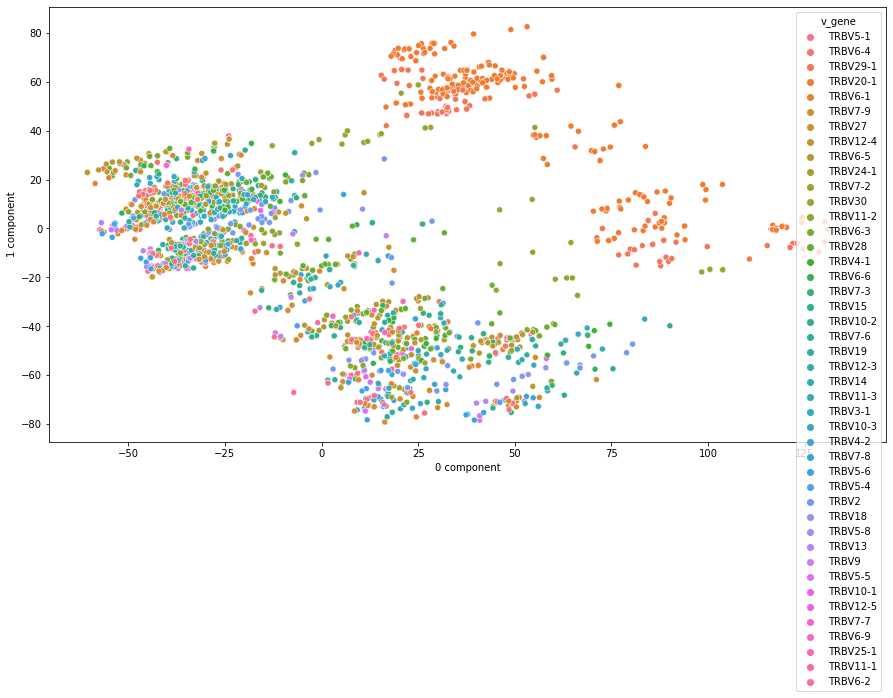

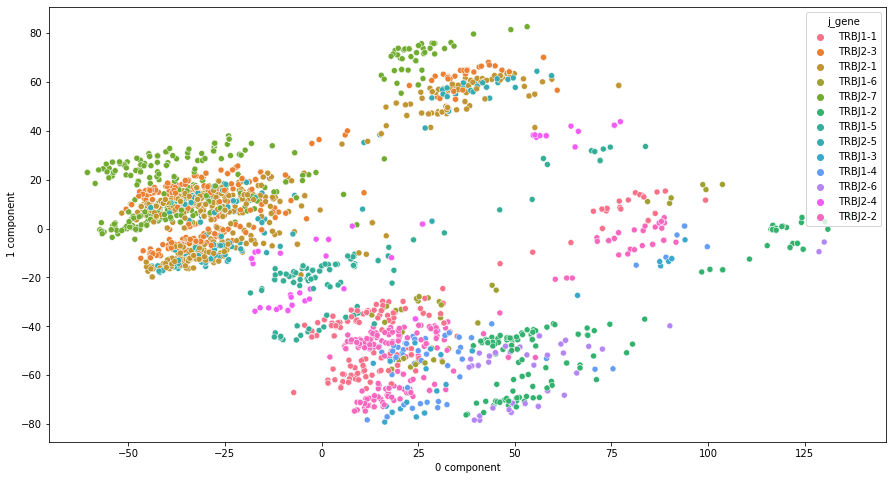

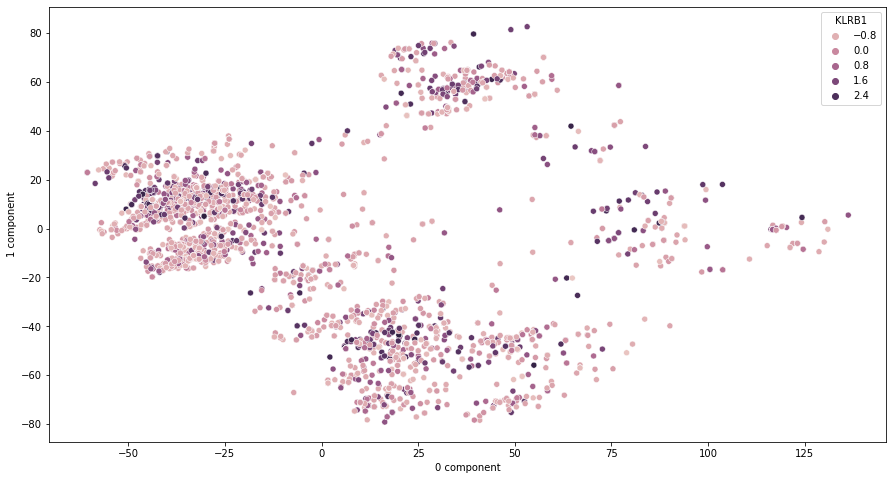

In [200]:
pc1 = 0
pc2 = 1
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data,hue='v_gene')
#ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data,hue='j_gene')
#ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data,hue='KLRB1')
#ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [201]:
from sklearn.feature_selection import f_classif
def pc_anova(data,pc_n, group):
    pc_anova = pd.DataFrame(columns=['pc','F','pvalue'])

    for n in range(0,pc_n):
        F,pval = f_classif(np.array(data[n]).reshape(-1,1),data[group])
        pc_anova = pc_anova.append({'pc': n ,'F': float(F),'pvalue':float(pval)},ignore_index=True)
    
    return pc_anova

In [202]:
pc_anova_df = pc_anova(pca_df_data,pc_n, 'KLRB1_bool')
pc_anova_df = pc_anova_df.sort_values('pvalue').reset_index(drop=True)
pc_selected = list(pc_anova_df['pc'].head(100))

In [109]:
import umap

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
from sklearn.preprocessing import StandardScaler

In [203]:
scaled_pca_df = StandardScaler().fit_transform(pca_df[pc_selected])

In [204]:
reducer = umap.UMAP()
umap_df = reducer.fit_transform(scaled_pca_df)
umap_df.shape

(5091, 2)

In [205]:
umap_df_data = pd.DataFrame(umap_df)
umap_df_data['barcode'] = data_c_b_dist.index
umap_df_data=umap_df_data.merge(data_b[['barcode','j_gene','v_gene','KLRB1']], on='barcode')

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'UMAP of ank spond data after PCA, colored by j_gene')

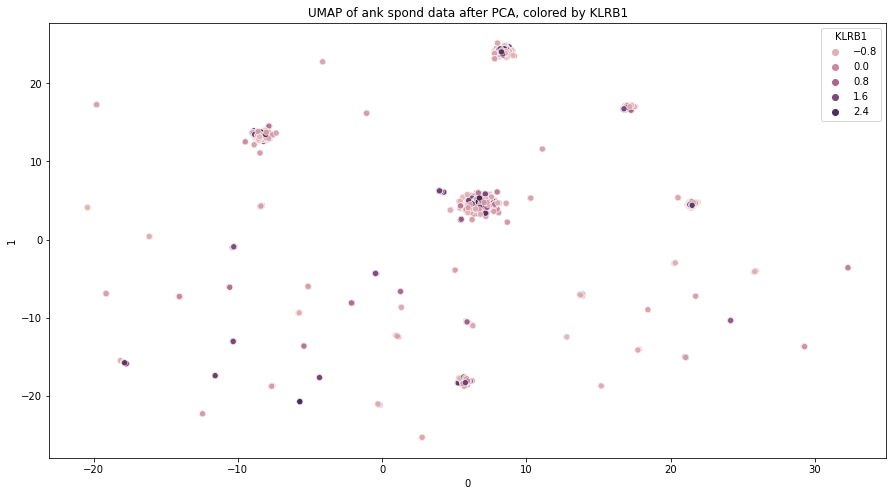

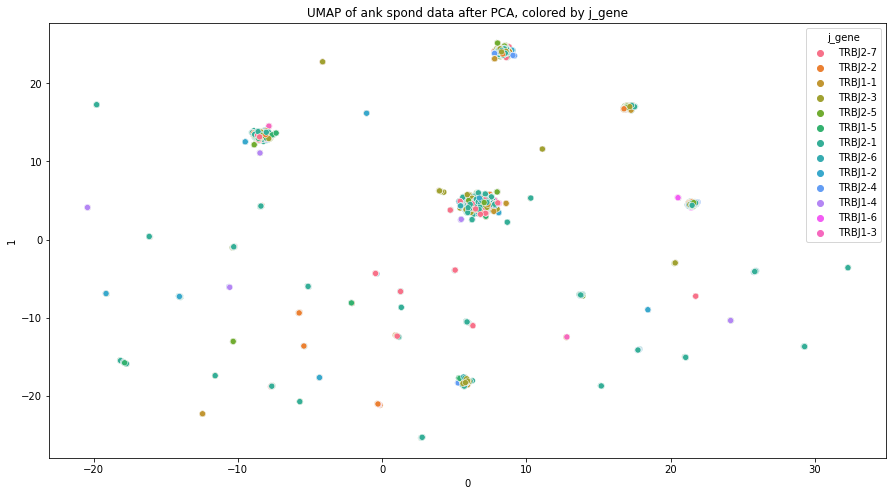

In [206]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(0, 1, data=umap_df_data, hue='KLRB1')
ax.set_title("UMAP of ank spond data after PCA, colored by KLRB1")
plt.figure(figsize=(15,8))
ax = sns.scatterplot(0, 1, data=umap_df_data, hue='j_gene')
ax.set_title("UMAP of ank spond data after PCA, colored by j_gene")

In [210]:
X_embedded = data_processing.tsne(pca_df[pc_selected],2,10,20)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
tsne_df_data['barcode'] = data_c_b_dist.index
tsne_df_data=tsne_df_data.merge(data_b[['barcode','j_gene','v_gene','KLRB1']], on='barcode')
#tsne_df_data= tsne_df_data.groupby(['cdr3']).first().reset_index()

tsne_df_data

,DM1,DM2,barcode,j_gene,v_gene,KLRB1
0,-71.222382,50.119202,ATTGGACGTCTCACCT,TRBJ2-7,TRBV7-6,-0.886413
1,-54.911339,-57.592735,AACTGGTTCTCCAGGG,TRBJ2-2,TRBV7-2,-0.823676
2,-54.913906,-57.591534,CATCAGAGTAAGAGGA,TRBJ2-2,TRBV7-2,-0.725173
3,-50.406483,-13.542534,CGCGGTACAGGGATTG,TRBJ1-1,TRBV11-2,1.587308
4,-72.245811,15.169427,GGTGAAGCACTCGACG,TRBJ2-3,TRBV7-3,0.353065
...,...,...,...,...,...,...
7286,-100.427109,-3.275553,GACGTTAGTAAGTTCC,TRBJ2-1,TRBV7-6,-0.704932
7287,28.147369,57.527916,AAAGTAGCACATGGGA,TRBJ2-7,TRBV6-1,-0.624472
7288,-3.105008,-35.616276,GACCAATTCTGCCCTA,TRBJ2-3,TRBV15,2.221175
7289,63.807087,79.824226,TCAGATGTCTTGCAAG,TRBJ1-2,TRBV6-5,-0.015075


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TSNE of ank spond data after PCA, colored by KLRB1')

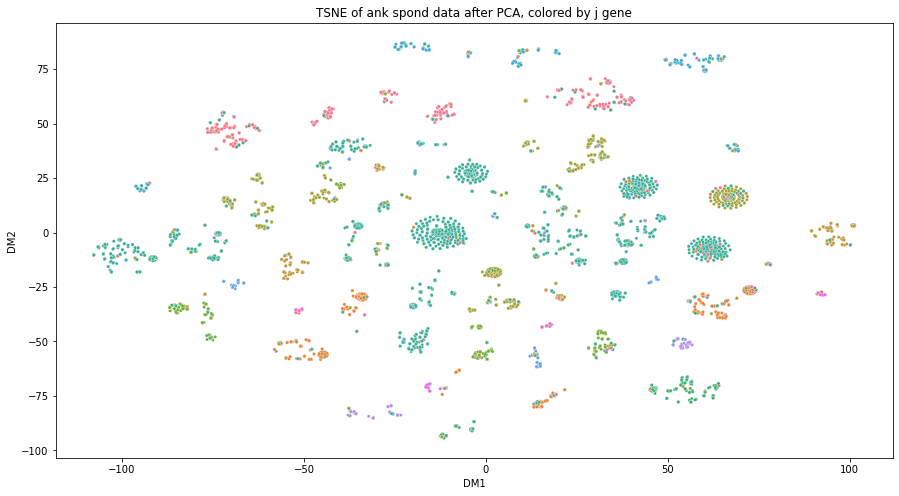

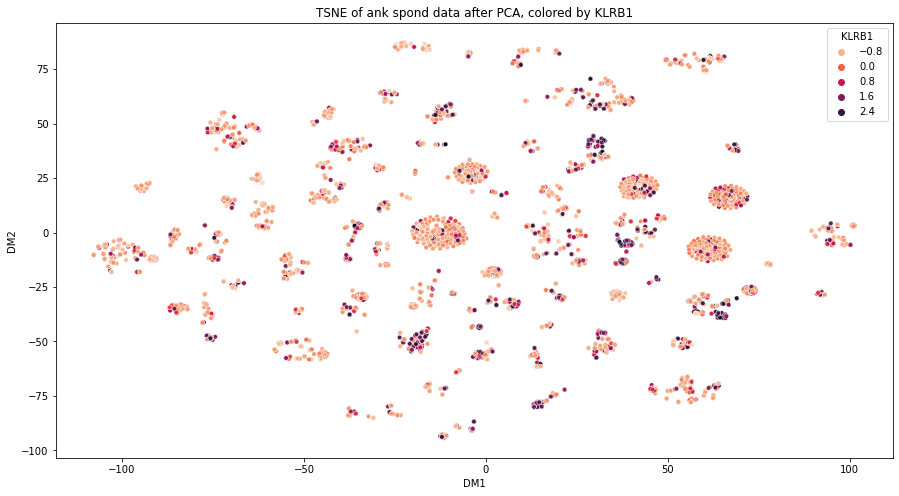

In [211]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='j_gene',s=10,legend = False)
ax.set_title("TSNE of ank spond data after PCA, colored by j gene")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='KLRB1',s=20,palette = 'rocket_r')
ax.set_title("TSNE of ank spond data after PCA, colored by KLRB1")

In [212]:
import re

In [219]:
motifs = ['CASS\wG\wYSTDTQYF','CASS\wG\wFSTDTQYF']

In [ ]:
if re.match('CASS\wG\wYSTDTQYF','CASSLGLYSTDTQYF')

In [224]:
l = re.match('CASS\wG\wYSTDTQYF','CASSLGLYSTDTQYF')


<_sre.SRE_Match object; span=(0, 15), match='CASSLGLYSTDTQYF'>


In [244]:
data[data['cdr3'].str.match('CASS.*G.*YSTDTQYF')==True]

,cloneId,barcode,tagQualityCELL,readCount,uniqueMoleculeCount,targetSequences,targetQualities,v_gene,allDHitsWithScore,j_gene,...,aaSeqCDR1,aaSeqFR2,aaSeqCDR2,aaSeqFR3,cdr3,aaSeqFR4,refPoints,chain,KLRB1,KLRB1_bool
1321,785,GCATGCGCACCAGATT,no_quality_for_tag,3361.0,9,ACNNTNNNCNTNNNNNGGNAAAGCTCCCATCCTGCCCTGACTCTGT...,[[!![!!![![!!!!![[![[[[[[[[[[[[[[[[[[[[[[[[[[[...,TRBV7-3*00(671.5),TRBD2*00(35),TRBJ2-3*00(410.8),...,SGHTA,LYWYRQSLGQGPEFLIY,FQGTGA,ADDSGLPNDRFFAVRPEGSVSTLKIQRTERGDSAVYL,CASSLSGYSTDTQYF,GPGTRLTVL_,16:47:96:96:104:182:197:248:266:377:-5:389:391...,TRB,-0.433535,0


In [ ]:
data[data['cdr3']=='CASSVGLFSTDTQYF']['cdr3'].str.match('CASS\wG\wYSTDTQYF')

In [241]:
data[data['cdr3']=='CASSVGLFSTDTQYF']['cdr3'].str.match(r'CASS.*G.*FSTDTQYF')

508    True
Name: cdr3, dtype: bool

In [232]:
data[505:510]

,cloneId,barcode,tagQualityCELL,readCount,uniqueMoleculeCount,targetSequences,targetQualities,v_gene,allDHitsWithScore,j_gene,...,aaSeqCDR1,aaSeqFR2,aaSeqCDR2,aaSeqFR3,cdr3,aaSeqFR4,refPoints,chain,KLRB1,KLRB1_bool
505,2,CGTCCATCAAGACACG,no_quality_for_tag,5512.0,15,AACTGGCAGACACCTGCCTGATGCTGCCATGGGCCCCCAGCTCCTT...,+*)+22)18228:8;99<<;AH:9:=::<@><>=@>?>?<<?<?@?...,TRBV27*00(594),TRBD2*00(35),TRBJ2-1*00(405.1),...,MNHEY,MSWYRQDPGLGLRQIYY,SMNVEV,TDKGDVPEGYKVSRKEKRNFPLILESPSPNQTSLYF,CASSLAGGPYNEQFF,GPGTRLTVL_,0:28:77:77:85:163:178:229:247:355:1:373:373:-1...,TRB,-0.419149,0
506,5,CGTCCATCAAGACACG,no_quality_for_tag,1650.0,5,AGAGAGAAGATACCGGTGTCGGGAAGCACCAGTGCCCTGAGGAAGG...,",-------1--0032903132882622226231226622236374?...",TRAV3*00(581.1),NaN,TRAJ34*00(486.4),...,VSGNPY,LFWYVQYPNRGLQFLLK,YITGDNLV,KGSYGFEAEFNKSQTSFHLKKPSALVSDSALYF,CAVRGPSYNTDKLIF,GTGTRLQVFP_,89:188:234:234:245:323:341:392:416:515:-3:528:...,TRA,-0.419149,0
507,270,CTACGTCCATGTCTCC,no_quality_for_tag,5494.0,11,"TTTAAAGATANNGNTACNNCNNNNANCTA,TCCTGCCCTGACCCTG...","//=DD!=[[[!![!([[!![!!!![![)[,+.*.*..--*-***.,...",TRBV11-1*00(674.4),TRBD2*00(25),TRBJ2-1*00(398.8),...,SGHAT,LYWYRQILGQGPELLVQ,FQDESV,VDDSQLPKDRFSAERLKGVDSTLKIQPAELGDSAMYL,CASSTLSAYNEQFF,GPGTRLTVL_,":::::::::::::::::::::,0:18:67:67:75:153:168:21...",TRB,-0.436174,0
508,469,GTTCATTCATTACGAC,no_quality_for_tag,5470.0,9,CCCAAGCTAGGAGATCCTGCCATGGGCTTCAGGCTCCTCTGCTGTG...,[*+[*+***[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[...,TRBV9*00(706.3),NaN,TRBJ2-3*00(418.5),...,SGDLS,VYWYQQSLDQGLQFLIQ,YYNGEE,RAKGNILERFSAQQFPDLHSELNLSSLELGDSALYF,CASSVGLFSTDTQYF,GPGTRLTVL_,0:21:70:70:78:156:171:222:240:348:0:364:::::37...,TRB,0.482391,1
509,3020,GTTCATTCATTACGAC,no_quality_for_tag,531.0,1,TACAATCTTTCCCTACACGACGCTCTTCCGATCTGTTCATTCATTA...,/<</![=[[R[[[[=[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[...,TRAV21*00(567.3),NaN,TRAJ57*00(483.4),...,DSAIYN,LQWFRQDPGKGLTSLLL,IQSSQRE,QTSGRLNASLDKSSGRSTLYIAASQPGDSATYL,CAVSTPQGGSEKLVF,GKGMKLTVNP_,83:182:228:228:239:317:335:386:407:506:-1:517:...,TRA,0.482391,1


In [ ]:
matrix_raw = pd.DataFrame(matrix.toarray())
matrix_2 = pd.DataFrame(columns=['barcode_id','feature_id','count'])
for row in range(0,len(matrix_raw)):
    for col in list(pd.DataFrame(matrix.toarray()).columns):
        matrix_2 = matrix_2.append({'barcode_id': col, 'feature_id': row, 'count':  matrix_raw[row][col]}, ignore_index=True)

data - counts
indices - index (row)
indptr - barcodes (column)